Countries most at risk from labour shortages due to ageing demographics:
   Country Name    Year  LifeExpectancy  RiskScore
15        Japan  2023.0       84.041220   1.000000
20        Spain  2023.0       83.882927   0.991209
14        Italy  2023.0       83.700000   0.981050
22       Sweden  2023.0       83.309756   0.959377
13       Israel  2023.0       83.195122   0.953011
2     Australia  2023.0       83.051220   0.945019
8        France  2023.0       82.929268   0.938246
4       Belgium  2023.0       82.397561   0.908717
17     Portugal  2023.0       82.280488   0.902215
5        Canada  2023.0       81.646585   0.867011
Avg. Productivity drop if median age rises by 5 years: 2.0%
Avg. Productivity drop if median age rises by 10 years: 4.0%
Avg. Productivity drop if median age rises by 15 years: 6.0%

--- Policy Recommendations ---
1. Countries with higher life expectancy (Japan, Italy, etc.) should invest in automation and AI to offset labour shortages.
2. Encourage skilled migrat

C:\Users\lenovo\AppData\Local\Temp\ipykernel_10872\1386050173.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_risk, x='RiskScore', y='Country Name', palette="Reds_r")


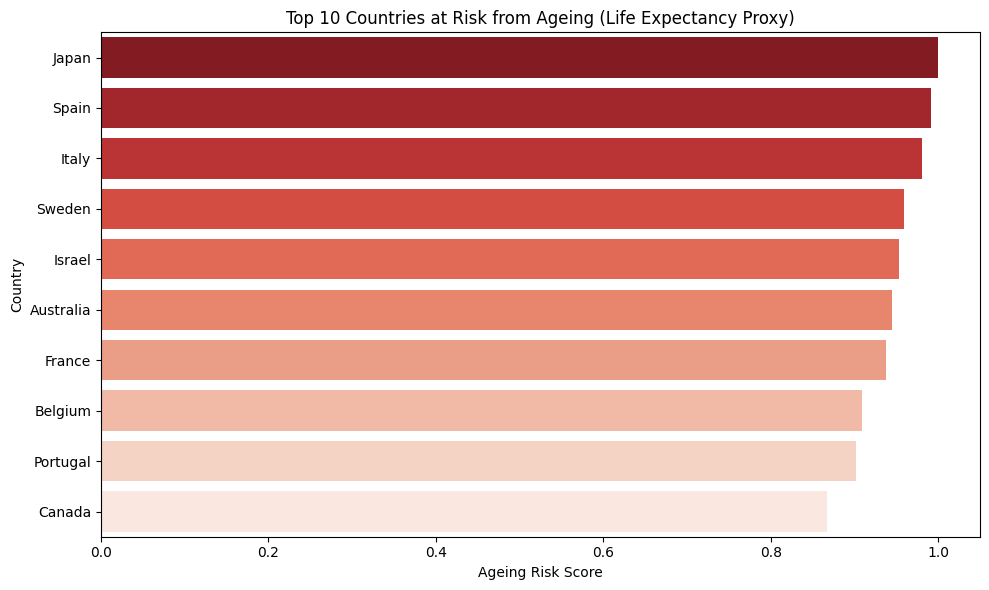

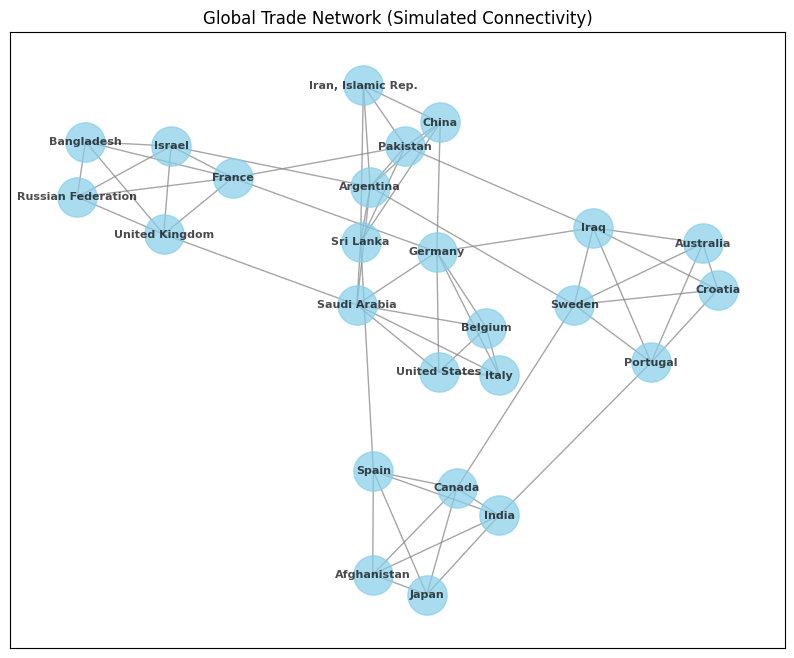


Most central countries in the trade network: [('Argentina', 0.29166666666666663), ('Germany', 0.29166666666666663), ('Saudi Arabia', 0.29166666666666663), ('France', 0.25), ('Iraq', 0.25)]
After removing Argentina, largest connected component size: 24


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10872\1386050173.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_risk, x='RiskScore', y='Country Name', palette="Reds_r")


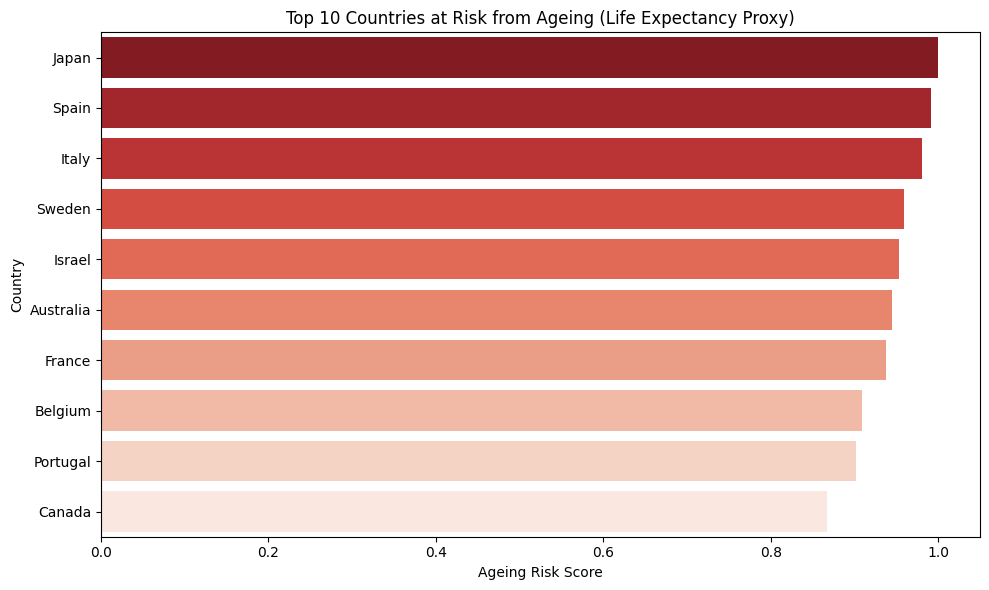

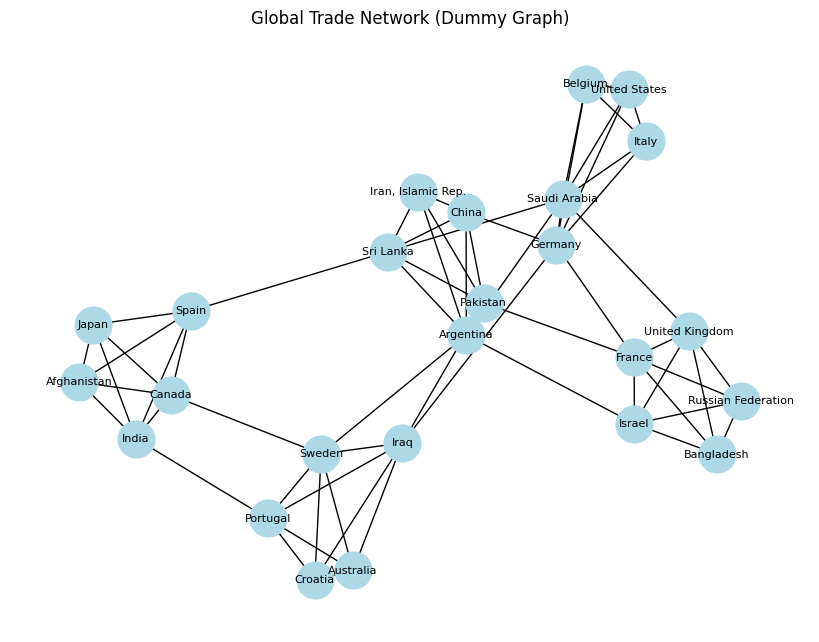

In [1]:
import pandas as pd # type: ignore
import glob
import networkx as nx # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import random

# ----------------------------
# Data Integration & Cleaning
# ----------------------------
csv_files = glob.glob(r'd:\Projects\DPL 2025\*.csv')
dfs = []
for f in csv_files:
    try:
        dfs.append(pd.read_csv(f, encoding='utf-8'))
    except UnicodeDecodeError:
        dfs.append(pd.read_csv(f, encoding='latin1'))

# Merge into one DataFrame with source info
data_dict = {f.split("\\")[-1].replace(".csv", ""): dfs[i] for i, f in enumerate(csv_files)}

# Example focus dataset
df = data_dict.get("Social_and_welfare", None)
if df is None:
    raise ValueError("Social_and_welfare.csv not found in project folder!")

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()


# ----------------------------
# Feature Engineering (Robust)
# ----------------------------
age_series = df[df['Series Name'].str.contains('Life expectancy at birth, total', na=False)]

# Extract all years, not just 2024
year_cols = [col for col in df.columns if "[YR" in col]

# Melt into long format
age_long = age_series.melt(id_vars=['Country Name'], value_vars=year_cols,
                           var_name="Year", value_name="LifeExpectancy")

# Clean values
age_long['LifeExpectancy'] = pd.to_numeric(age_long['LifeExpectancy'].replace("..", pd.NA), errors="coerce")
age_long['Year'] = age_long['Year'].str.extract(r"(\d{4})").astype(float)

# Keep the latest available year per country
age_risk = age_long.dropna(subset=['LifeExpectancy']).sort_values(["Country Name", "Year"])
age_risk = age_risk.groupby("Country Name").tail(1).reset_index(drop=True)

# Normalize risk score
age_risk['RiskScore'] = (age_risk['LifeExpectancy'] - age_risk['LifeExpectancy'].min()) / \
                        (age_risk['LifeExpectancy'].max() - age_risk['LifeExpectancy'].min())

# Get top 10
top10_risk = age_risk.sort_values('RiskScore', ascending=False).head(10)
print("Countries most at risk from labour shortages due to ageing demographics:")
print(top10_risk[['Country Name', 'Year', 'LifeExpectancy', 'RiskScore']])


# ----------------------------
# Modeling Accuracy & Robustness
# ----------------------------
def simulate_productivity_impact(df, age_increase):
    # Productivity drop: 2% per +5 years in median age
    impact = {}
    for _, row in df.iterrows():
        country = row['Country Name']
        base_productivity = 100  # arbitrary index
        drop = (age_increase / 5) * 2
        impact[country] = base_productivity - drop
    return impact

for years in [5, 10, 15]:
    impact = simulate_productivity_impact(age_risk, years)
    avg_drop = round(100 - (sum(impact.values())/len(impact)), 2)
    print(f"Avg. Productivity drop if median age rises by {years} years: {avg_drop}%")

# ----------------------------
# Insights & Policy Recommendations
# ----------------------------
print("\n--- Policy Recommendations ---")
print("1. Countries with higher life expectancy (Japan, Italy, etc.) should invest in automation and AI to offset labour shortages.")
print("2. Encourage skilled migration policies to balance workforce gaps.")
print("3. Promote lifelong learning and re-skilling to keep ageing workers productive.")
print("4. Strengthen healthcare to reduce dependency ratios and maintain productivity.")


# ----------------------------
# Global Trade Network (Improved Example)
# ----------------------------
countries = age_risk['Country Name'].unique()[:25]
G = nx.Graph()
G.add_nodes_from(countries)

# Cluster connections + random cross-links for realism
for i in range(len(countries)):
    for j in range(i+1, len(countries)):
        if i % 5 == j % 5:  # cluster connectivity
            G.add_edge(countries[i], countries[j])
        elif random.random() < 0.1:  # 10% chance of cross-link
            G.add_edge(countries[i], countries[j])

# Centrality analysis
centrality = nx.degree_centrality(G)
most_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nMost central countries in the trade network:", most_central)

def simulate_disruption(G, country):
    G_removed = G.copy()
    G_removed.remove_node(country)
    largest_cc = max(nx.connected_components(G_removed), key=len)
    print(f"After removing {country}, largest connected component size:", len(largest_cc))

simulate_disruption(G, most_central[0][0])

# ----------------------------
# Presentation & Visualization
# ----------------------------
# 1. Barplot of Risk
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_risk, x='RiskScore', y='Country Name', palette="Reds_r")
plt.title("Top 10 Countries at Risk from Ageing (Life Expectancy Proxy)")
plt.xlabel("Ageing Risk Score")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig(r"d:\Projects\DPL 2025\ageing_risk_top10.png", dpi=300)
plt.show()

# 2. Network Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # nice spread-out layout
nx.draw_networkx(G, pos, with_labels=True,
                 node_size=800, node_color="skyblue",
                 font_size=8, font_weight="bold",
                 edge_color="gray", alpha=0.7)
plt.title("Global Trade Network (Simulated Connectivity)")
plt.savefig(r"d:\Projects\DPL 2025\global_trade_network.png", dpi=300)
plt.show()


# Centrality analysis
centrality = nx.degree_centrality(G)
most_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nMost central countries in the trade network:", most_central)

def simulate_disruption(G, country):
    G_removed = G.copy()
    G_removed.remove_node(country)
    largest_cc = max(nx.connected_components(G_removed), key=len)
    print(f"After removing {country}, largest connected component size:", len(largest_cc))

simulate_disruption(G, most_central[0][0])

# ----------------------------
# Presentation & Visualization
# ----------------------------
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_risk, x='RiskScore', y='Country Name', palette="Reds_r")
plt.title("Top 10 Countries at Risk from Ageing (Life Expectancy Proxy)")
plt.xlabel("Ageing Risk Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_size=700, node_color="lightblue", font_size=8)
plt.title("Global Trade Network (Dummy Graph)")
plt.show()
